라이브러리 로딩 및 한글 폰트 설정 문제 없음

데이터 로딩 중
CSV 파일 로드 완료! 총 366개 레코드

시각화 이미지 생성 중...


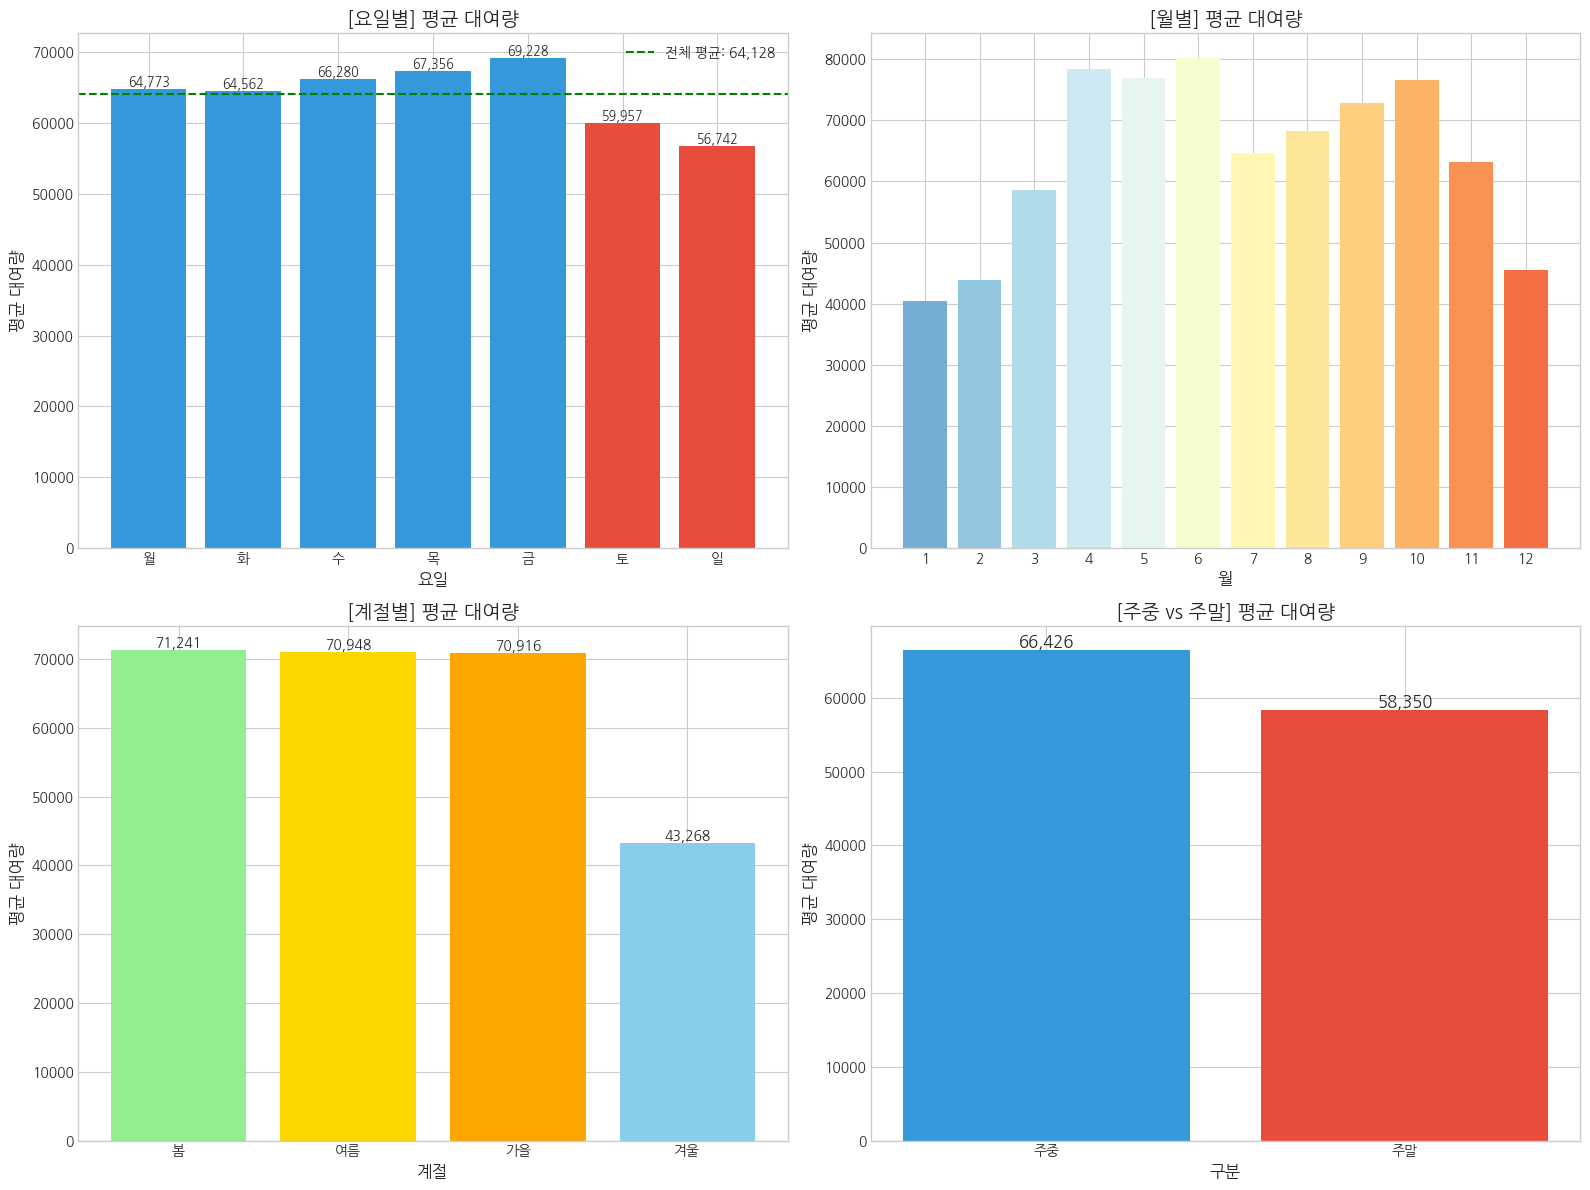

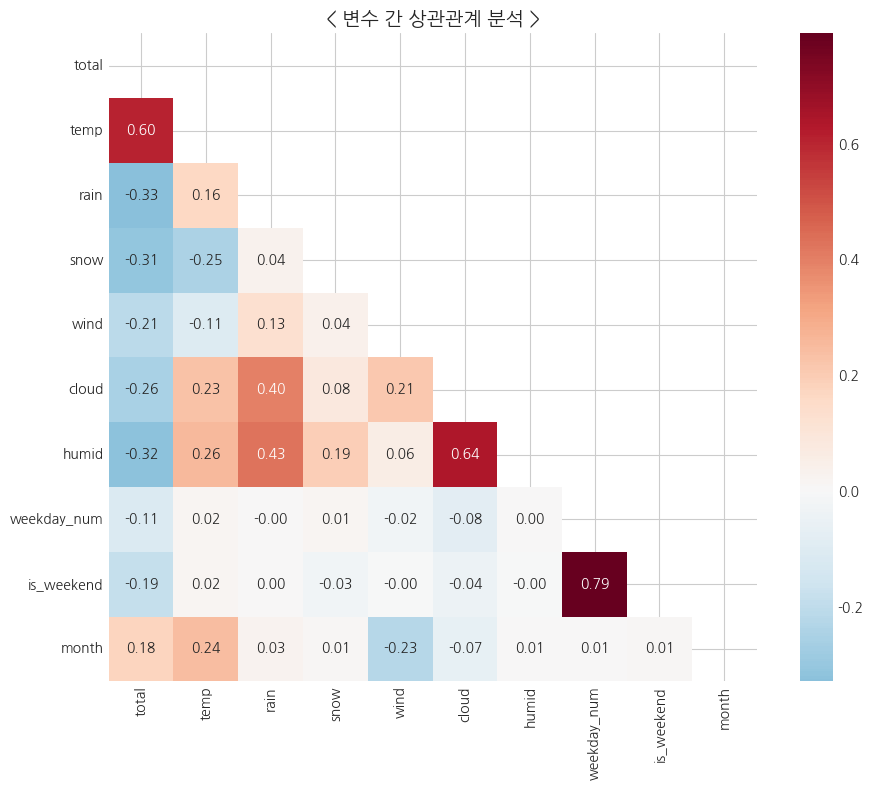

시각화 작업 끝

모델 학습 진행 중...
  └─ Linear Regression: R²=0.7810
  └─ Random Forest: R²=0.9032
  └─ XGBoost: R²=0.8960
  └─ LightGBM: R²=0.8792

모델 성능 시각화...


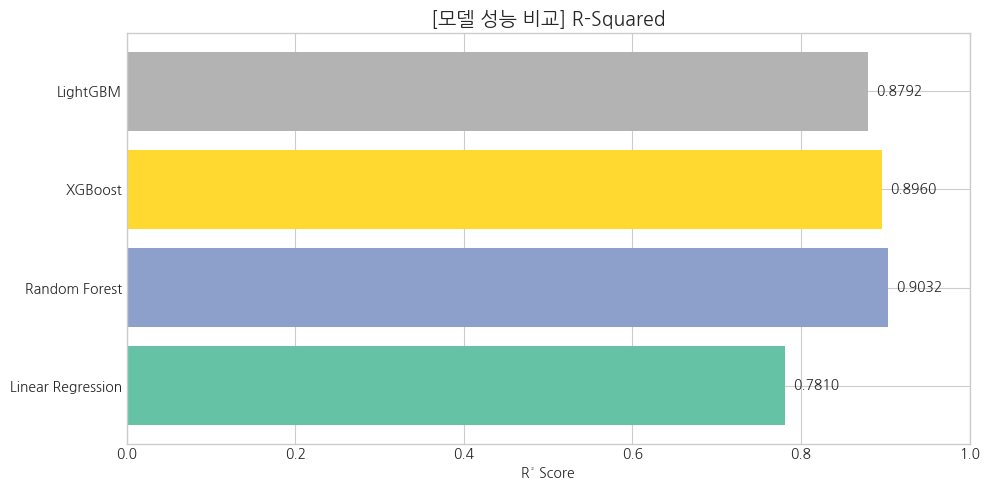

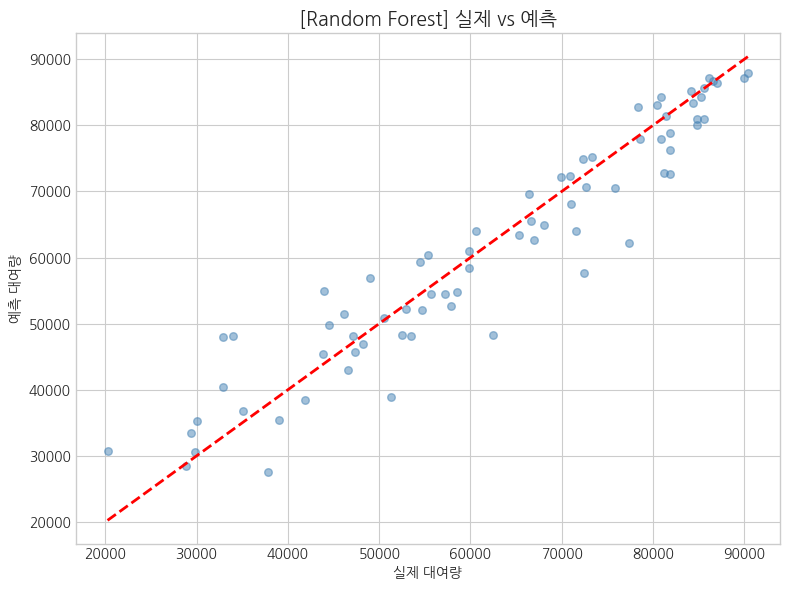


최고 성능 모델 저장 중...
  └─ 선정된 모델: Random Forest
  └─ 성능 (R²): 0.9032
  └─ 파일 저장 완료: best_bike_model.pkl

모든 분석 완료!


In [2]:
# ============================================
# 서울시 따릉이 대여량 예측 모델 (최종 수정 + 모델 저장 추가)
# ============================================

# 1. 라이브러리 설치 및 폰트 설정
# --------------------------------------------
! pip install -q xgboost lightgbm
! apt-get -qq install fonts-nanum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import warnings
from datetime import datetime

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 스타일 설정 후 폰트 설정
plt.style.use('seaborn-v0_8-whitegrid')

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# ML 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle

print("라이브러리 로딩 및 한글 폰트 설정 문제 없음")

# ============================================
# 2. 데이터 로드 및 전처리
# ============================================

print("\n데이터 로딩 중")

try:
    df = pd.read_csv('/content/final_dataset_detailed.csv')
    print(f"CSV 파일 로드 완료! 총 {len(df):,}개 레코드")
except FileNotFoundError:
    print("파일 로딩 실패: 경로를 확인해주세요.")

# 날짜 컬럼 처리
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['weekday_num'] = df['date'].dt.weekday # 원본 CSV 파일의 데이터가 문자라서 숫자로 변환
    df['weekday'] = df['date'].dt.day_name().map({'Monday':'월','Tuesday':'화','Wednesday':'수','Thursday':'목','Friday':'금','Saturday':'토','Sunday':'일'}) # 데이터를 숫자로 보여줄 수는 없으니까 매핑
    df['is_weekend'] = df['weekday_num'].apply(lambda x: 1 if x >= 5 else 0)
    df['season'] = df['month'].apply(lambda x: 1 if x in [3,4,5] else (2 if x in [6,7,8] else (3 if x in [9,10,11] else 4)))
    df = df.fillna(0)

# ============================================
# 3. 탐색적 데이터 분석 (EDA) 및 시각화
# ============================================

def create_visualizations(df):
    """다양한 시각화 생성"""

    # ---- 3.1 요일별 & 월별 대여량 분석 ----
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 요일별
    day_order = ['월', '화', '수', '목', '금', '토', '일']
    daily_avg = df.groupby('weekday')['total'].mean().reindex(day_order)
    ax1 = axes[0, 0]
    colors = ['#3498db' if i < 5 else '#e74c3c' for i in range(7)]
    bars = ax1.bar(daily_avg.index, daily_avg.values, color=colors)
    ax1.set_xlabel('요일', fontsize=12)
    ax1.set_ylabel('평균 대여량', fontsize=12)
    ax1.set_title('[요일별] 평균 대여량', fontsize=14, fontweight='bold')
    ax1.axhline(y=daily_avg.mean(), color='green', linestyle='--', label=f'전체 평균: {daily_avg.mean():,.0f}')
    ax1.legend()
    for bar, val in zip(bars, daily_avg.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,.0f}', ha='center', va='bottom', fontsize=9)

    # 월별
    monthly_avg = df.groupby('month')['total'].mean()
    ax2 = axes[0, 1]
    month_colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 12))
    ax2.bar(monthly_avg.index, monthly_avg.values, color=month_colors)
    ax2.set_xlabel('월', fontsize=12)
    ax2.set_ylabel('평균 대여량', fontsize=12)
    ax2.set_title('[월별] 평균 대여량', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(1, 13))

    # 계절별
    season_names = ['봄', '여름', '가을', '겨울']
    season_avg = df.groupby('season')['total'].mean()
    ax3 = axes[1, 0]
    season_colors = ['#90EE90', '#FFD700', '#FFA500', '#87CEEB']
    bars = ax3.bar(season_names, season_avg.values, color=season_colors)
    ax3.set_xlabel('계절', fontsize=12)
    ax3.set_ylabel('평균 대여량', fontsize=12)
    ax3.set_title('[계절별] 평균 대여량', fontsize=14, fontweight='bold')
    for bar, val in zip(bars, season_avg.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,.0f}', ha='center', va='bottom', fontsize=10)

    # 주중 vs 주말
    weekend_avg = df.groupby('is_weekend')['total'].mean()
    ax4 = axes[1, 1]
    weekend_labels = ['주중', '주말']
    bars = ax4.bar(weekend_labels, weekend_avg.values, color=['#3498db', '#e74c3c'])
    ax4.set_xlabel('구분', fontsize=12)
    ax4.set_ylabel('평균 대여량', fontsize=12)
    ax4.set_title('[주중 vs 주말] 평균 대여량', fontsize=14, fontweight='bold')
    for bar, val in zip(bars, weekend_avg.values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,.0f}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    # ---- 3.2 상관관계 히트맵 ----
    fig, ax = plt.subplots(figsize=(10, 8))
    corr_cols = ['total', 'temp', 'rain', 'snow', 'wind', 'cloud', 'humid', 'weekday_num', 'is_weekend', 'month']
    corr_matrix = df[corr_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True)
    ax.set_title('< 변수 간 상관관계 분석 >', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("시각화 작업 끝")

print("\n시각화 이미지 생성 중...")
create_visualizations(df)

# ============================================
# 4. 피처 엔지니어링 & 모델링
# ============================================

def prepare_features(df):
    feature_df = df.copy()
    feature_cols = ['weekday_num', 'is_weekend', 'month', 'season', 'temp', 'rain', 'snow', 'wind', 'cloud', 'humid', 'is_rain', 'is_snow']
    feature_df['feels_like'] = feature_df['temp'] - 0.4 * (1 - feature_df['humid']/100) * (feature_df['temp'] - 10)
    feature_cols.append('feels_like')
    feature_df['bad_weather_index'] = (feature_df['is_rain'] * 2 + feature_df['is_snow'] * 2 + feature_df['wind'] / 10 + feature_df['cloud'] / 100)
    feature_cols.append('bad_weather_index')
    return feature_df[feature_cols], feature_df['total'], feature_cols

print("\n모델 학습 진행 중...")
X, y, feature_cols = prepare_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
        'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1),
        'LightGBM': LGBMRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
    }
    results = []
    trained = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        trained[name] = model
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'R²': r2})
        print(f"  └─ {name}: R²={r2:.4f}")

    return trained, pd.DataFrame(results)

trained_models, results_df = train_models(X_train, X_test, y_train, y_test)

# ============================================
# 5. 모델 성능 시각화
# ============================================

def visualize_performance(results_df, trained_models, X_test, y_test):
    # R² 비교
    plt.figure(figsize=(10, 5))
    colors = plt.cm.Set2(np.linspace(0, 1, len(results_df)))
    bars = plt.barh(results_df['Model'], results_df['R²'], color=colors)
    plt.xlabel('R² Score')
    plt.title('[모델 성능 비교] R-Squared', fontsize=14, fontweight='bold')
    plt.xlim(0, 1)
    for bar, val in zip(bars, results_df['R²']):
        plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')
    plt.tight_layout()
    plt.show()

    # 최고 모델 산점도
    best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
    best_model = trained_models[best_model_name]
    y_pred = best_model.predict(X_test)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, s=30, c='steelblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('실제 대여량')
    plt.ylabel('예측 대여량')
    plt.title(f'[{best_model_name}] 실제 vs 예측', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n모델 성능 시각화...")
visualize_performance(results_df, trained_models, X_test, y_test)

# ============================================
# 6. 최고 성능 모델 저장 (추가된 부분)
# ============================================

print("\n최고 성능 모델 저장 중...")

# 가장 높은 R2 점수를 가진 모델 식별
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2_score = results_df.loc[best_model_idx, 'R²']
final_model = trained_models[best_model_name]

# 모델 저장 (Pickle 사용)
save_filename = 'best_bike_model.pkl'
with open(save_filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"  └─ 선정된 모델: {best_model_name}")
print(f"  └─ 성능 (R²): {best_r2_score:.4f}")
print(f"  └─ 파일 저장 완료: {save_filename}")

print("\n모든 분석 완료!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

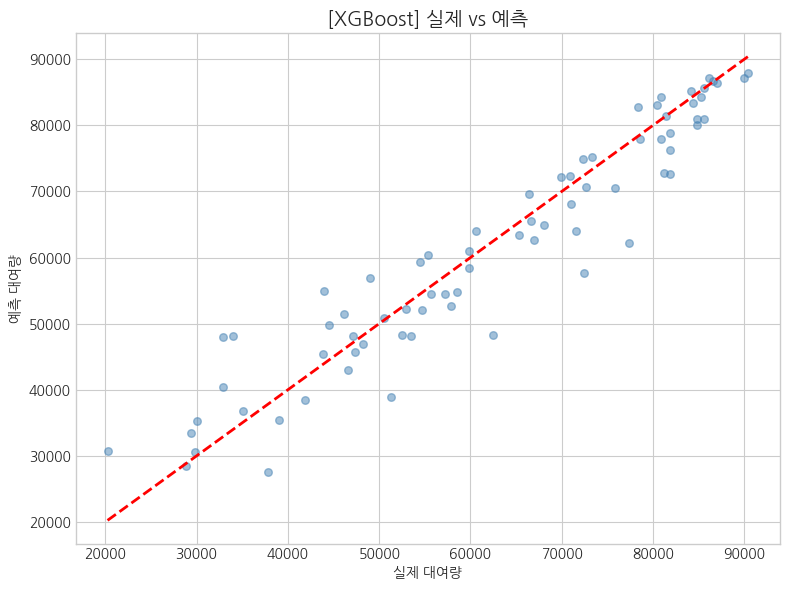

In [ ]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=30, c='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 대여량')
plt.ylabel('예측 대여량')
plt.title(f'[{best_model_name}] 실제 vs 예측', fontsize=14, fontweight='bold') # 이모지 제거
plt.tight_layout()
plt.show()